In [1]:
import torch, numpy, pickle, sys
sys.path.append('/home/dgotzens/scripts')
import pdfdefaults as pdf
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt,log10,atan2
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pi = 3.141592653589 
maxdist = 50
c0 = 299_792_458 
f0, f1 = 76_009_996_288.0, 80_289_505_280.0
omega0, omega1 = 2*pi*f0, 2*pi*f1

t_chirp = 0.000_064_890_002_249_740_060
fs = 22e6
Ts=1/fs

omegadot = (omega1-omega0)/t_chirp

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry,vx,vy = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY'], params['vxPosX'], params['vxPosY']

M=1022
K=len(tx)
ula_idx = torch.full((max(vx)+1,max(vy)+1), -1)
for k, (x,y) in enumerate(zip(vx,vy)):
    if ula_idx[x,y] == -1:
        ula_idx[x,y] = k

def calc_image(data, weights, settings):
    # range FFT
    N, window = settings['N_range'], settings['range_window']
    range_fft = torch.fft.fft(window[:,None]*data, N, 0)
    range_fft /= window.sum()
    # apply calibration
    range_fft /= weights        

    
    if not settings['enable_elevation']:
        N, window = settings['N_azm'], settings['azm_window']
        ula = settings['ula_idx'][:,0]
        azimuth_fft = torch.fft.fftshift(torch.fft.fft(window*range_fft[:,ula],N,1),1)
        return azimuth_fft
    
    # reshape into ULA
    idx = settings['ula_idx']
    padded_shape = (settings['N_range'], *idx.shape)
    fft_padded = torch.zeros(padded_shape, dtype=torch.cfloat)

    for m in range(idx.shape[0]):
        for n in range(idx.shape[1]):
            if idx[m,n] >= 0:
                fft_padded[:,m,n] = range_fft[:,idx[m,n]]
    
    # azimuth FFT
    N, window = settings['N_azm'], settings['azm_window']
    azimuth_fft = torch.fft.fft(window[None,:,None]*fft_padded,N,1)
    azimuth_fft /= window.sum()

    # deconvolve
    gaps = idx>=0
    gaps_fft = torch.fft.fft(window[:,None]*gaps, N, 0)
    azimuth_fft /= (gaps_fft+1) # +1 to avoid divergence
    # elevation FFT
    N, window = settings['N_elv'], settings['elv_window']
    elevation_fft = torch.fft.fft(window*azimuth_fft, N, 2)
    elevation_fft /= window.sum()
    
    return elevation_fft

def r_est(R, theta0, K=192):
    # 3xK
    txpos = torch.tensor([tx,ty,[0]*K])
    rxpos = torch.tensor([rx,ry,[0]*K])
    # 3x1xR
    reflpos = R[None,None,:]*torch.tensor([-sin(-theta0), 0, cos(-theta0)])[:,None,None]
    # 3xKx1 - 3x1xR = 3xKxR -> KxR
    return 0.5*torch.sqrt(((txpos[:,:,None]-reflpos)**2).sum(0))\
          + 0.5*torch.sqrt(((rxpos[:,:,None]-reflpos)**2).sum(0))

dBr = lambda x: 20*(x/x.abs().max()).log10()

folder = '/home/dgotzens/scripts/3.1_imaging/example_img/'
data = torch.load(folder+'statische_szene_turm-im-hintergrund_data.pt')[:,:,25*50:]
M,K,L = data.shape
print(data.shape)

torch.Size([1022, 192, 674])


In [2]:
X,Z = 240,150
vid = torch.empty((Z,X,L), dtype=torch.cfloat)
vid_calib = torch.empty((Z,X,L), dtype=torch.cfloat)

settings = {
    'N_range': 2048,
    'N_azm':   512,
    'range_window': torch.hann_window(M),
    'azm_window': torch.hann_window(ula_idx.shape[0]),
    'ula_idx': ula_idx,
    'enable_elevation': False,
    'resolution' : (X,0,Z)
}

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
calib = torch.load(folder+'schwenks_channelgains.pt')

fft_vid = torch.empty((settings['N_range'],settings['N_azm'],L))
fft_vid_calib = torch.empty((settings['N_range'],settings['N_azm'],L))
for l in range(L):
    fft_vid[:,:,l] = calc_image(data[:,:,l], torch.ones(K),settings).abs()
    fft_vid_calib[:,:,l] = calc_image(data[:,:,l], calib, settings).abs()

x = torch.linspace(-12,12,X)
y = torch.linspace(0,15,Z)
r = torch.sqrt(x[:,None]**2 + y**2)
theta = torch.atan2(-x[:,None], y)
m_idx = (r/maxdist * settings['N_range'])
k_idx = ((theta.sin()+1)/2*(settings['N_azm']-1))

for x in range(X):
    for y in range(Z):
        m = int(m_idx[x,y])
        k = int(k_idx[x,y])
        vid[y,x,:]=fft_vid[m,k,:]
        vid_calib[y,x]=fft_vid_calib.abs()[m,k,:]

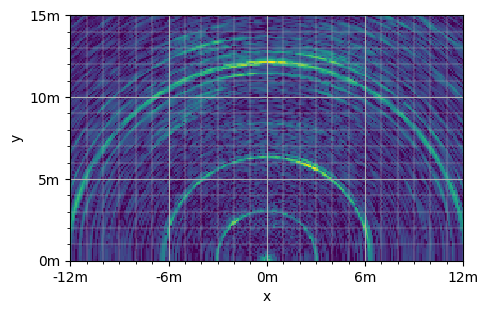

In [4]:
fig, ax = plt.subplots(1)
def animate(l):
    ax.clear()
    ax.pcolormesh(dBr(vid[:,:,l].abs()), vmin=-65, cmap='viridis', rasterized=True)
    ax.set_aspect('equal')
    X,Y,Z = settings['resolution']
    ax.set_xticks(torch.linspace(0,X,5).int(), [f'{x}m' for x in range(-12,12+1,6)])
    ax.set_xticks(torch.linspace(0,X,25), minor=True)
    ax.set_xlabel('x')
    ax.set_yticks(torch.linspace(0,Z,4).int(), [f'{z}m' for z in range(0,15+1,5)])
    ax.set_yticks(torch.linspace(0,Z,16), minor=True)
    ax.set_ylabel('y')
    
    ax.grid()
    ax.grid(which='minor', linewidth=0.3)
    fig.set_size_inches(0.8*pdf.a4_textwidth, 0.6*pdf.a4_textwidth)

anim = FuncAnimation(fig, animate, interval=40, frames=L)
anim.save('/home/dgotzens/Schreibtisch/fft_uncalibrated.mp4', dpi=300)

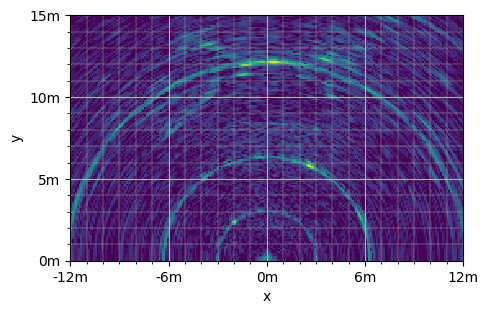

In [5]:
fig, ax = plt.subplots(1)
def animate(l):
    ax.clear()
    ax.pcolormesh(dBr(vid_calib[:,:,l].abs()), vmin=-65, cmap='viridis', rasterized=True)
    ax.set_aspect('equal')
    X,Y,Z = settings['resolution']
    ax.set_xticks(torch.linspace(0,X,5).int(), [f'{x}m' for x in range(-12,12+1,6)])
    ax.set_xticks(torch.linspace(0,X,25), minor=True)
    ax.set_xlabel('x')
    ax.set_yticks(torch.linspace(0,Z,4).int(), [f'{z}m' for z in range(0,15+1,5)])
    ax.set_yticks(torch.linspace(0,Z,16), minor=True)
    ax.set_ylabel('y')
    
    ax.grid()
    ax.grid(which='minor', linewidth=0.3)
    fig.set_size_inches(0.8*pdf.a4_textwidth, 0.6*pdf.a4_textwidth)

anim2 = FuncAnimation(fig, animate, interval=40, frames=L)
anim2.save('/home/dgotzens/Schreibtisch/fft_calibrated.mp4', dpi=300)